In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_file(filepath):

    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Parse the number of jobs and machines
    num_jobs, num_machines = map(int, lines[4].strip().split())

    # Initialize matrices for processing times and machine sequences
    processing_times = np.zeros((num_jobs, num_machines), dtype=int)
    machine_sequences = np.zeros((num_jobs, num_machines), dtype=int)

    # Parse job data
    for i, line in enumerate(lines[5:5 + num_jobs]):
        data = list(map(int, line.strip().split()))
        machine_sequences[i] = data[0::2]  # Extract machine IDs
        processing_times[i] = data[1::2]  # Extract processing times

    return num_jobs, num_machines, processing_times, machine_sequences

In [3]:
filepath = 'Data/la01.txt'
num_jobs, num_machines, processing_times, machine_sequences = read_file(filepath)
print("Number of Jobs:", num_jobs)
print("Number of Machines:", num_machines)
print("Processing Times:\n", processing_times)
print("Machine Sequences:\n", machine_sequences)

Number of Jobs: 10
Number of Machines: 5
Processing Times:
 [[21 53 95 55 34]
 [21 52 16 26 71]
 [39 98 42 31 12]
 [77 55 79 66 77]
 [83 34 64 19 37]
 [54 43 79 92 62]
 [69 77 87 87 93]
 [38 60 41 24 83]
 [17 49 25 44 98]
 [77 79 43 75 96]]
Machine Sequences:
 [[1 0 4 3 2]
 [0 3 4 2 1]
 [3 4 1 2 0]
 [1 0 4 2 3]
 [0 3 2 1 4]
 [1 2 4 0 3]
 [3 4 1 2 0]
 [2 0 1 3 4]
 [3 1 4 0 2]
 [4 3 2 1 0]]


# Generate initial population

In [4]:
def generate_init_pop(population_size, j, m):
    population_list = np.zeros((population_size, int(j*m)), dtype = np.int32)
    chromosome = np.zeros(j*m)
    start = 0
    for i in range(j): # every job needs m operations
        chromosome[start:start+m] = i
        start += m

    for i in range(population_size):
        np.random.shuffle(chromosome)
        population_list[i] = chromosome
    
    return population_list

# Fitness: compute makespan

In [5]:
# Fitness
def compute_makespan(chromosome, p_t, m_seq):
    op_count = np.zeros(p_t.shape[0], dtype = np.int32) # operation counter to keep track of which task of the job is next (task index)
    j_time = np.zeros(p_t.shape[0])
    m_time = np.zeros(p_t.shape[1])

    for j in chromosome:
        completion_t = max(j_time[j], m_time[m_seq[j,op_count[j]]]) + p_t[j,op_count[j]]
        j_time[j] = completion_t
        m_time[m_seq[j,op_count[j]]] = completion_t
        op_count[j] += 1

    makespan = max(j_time)

    return makespan

# Selection

### Roulette wheeel

In [6]:
def roulette_wheel_selection(populationlist, makespan_list):
    num_self_select = int(0.2*len(populationlist)/2)
    num_roulette_wheel = int(len(populationlist)/2) - num_self_select
    zipped = list(zip(makespan_list, np.arange(len(makespan_list))))
    sorted_zipped = sorted(zipped, key=lambda x: x[0])
    zipped = zip(*sorted_zipped)
    self_select_id = np.asarray(list(zipped)[1])[:num_self_select]
    
    makespan_list = 1/makespan_list
    selection_prob = makespan_list/sum(makespan_list)
    roulette_wheel_id = np.random.choice(len(populationlist), size = num_roulette_wheel, p = selection_prob)
    new_population = np.concatenate((copy.deepcopy(populationlist)[self_select_id],copy.deepcopy(populationlist)[roulette_wheel_id]), axis=0)
    
    return new_population

### Torunament selection

In [7]:
def tournament_selection(populationlist, makespan_list, tournament_size):

    new_population = []
    num_individuals = len(populationlist)
    
    for _ in range(num_individuals // 2):  # Half of the population for the next generation
        # Randomly choose `tournament_size = 3` individuals for the tournament
        participants = np.random.choice(range(num_individuals), tournament_size, replace=False)
        
        # Find the participant with the best fitness (minimum makespan)
        best_participant = min(participants, key=lambda idx: makespan_list[idx])
        
        # Add the best individual to the new population
        new_population.append(populationlist[best_participant])
    
    # Convert the new population to a numpy array
    return new_population


### Binary selection

In [8]:
def binary_selection(populationlist, makespan_list):
    new_population = np.zeros((int(len(populationlist)/2), populationlist.shape[1]), dtype = np.int32)
    
    num_self_select = int(0.1*len(populationlist)/2)
    num_binary = int(len(populationlist)/2) - num_self_select
    zipped = list(zip(makespan_list, np.arange(len(makespan_list))))
    sorted_zipped = sorted(zipped, key=lambda x: x[0])
    zipped = zip(*sorted_zipped)
    self_select_id = np.asarray(list(zipped)[1])[:num_self_select]
    
    for i in range(num_binary):
        select_id = np.random.choice(len(makespan_list), 2, replace=False)
        if makespan_list[select_id[0]] < makespan_list[select_id[1]]:
            new_population[i] = populationlist[select_id[0]]
        else:
            new_population[i] = populationlist[select_id[1]]
    
    new_population[-num_self_select:] = copy.deepcopy(populationlist)[self_select_id]
    
    return new_population

# Crossover

### Two-point-crossover

In [9]:
def two_point_crossover(populationlist, crossover_rate):
    
    parentlist = copy.deepcopy(populationlist)
    childlist = copy.deepcopy(populationlist)
    
    for i in range(len(parentlist),2):
        sample_prob=np.random.rand()
        if sample_prob <= crossover_rate:
            cutpoint = np.random.choice(2, parentlist.shape[1], replace = False)
            cutpoint.sort()
            parent_1 = parentlist[i]
            parent_2 = parentlist[i+1]
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            child_1[cutpoint[0]:cutpoint[1]] = parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]] = parent_1[cutpoint[0]:cutpoint[1]]
            childlist[i] = child_1
            childlist[i+1] = child_2
    
    return parentlist, childlist

### Job-order-crossover

In [10]:
def job_order_crossover(populationlist, j, crossover_rate, *args):
    parentlist = copy.deepcopy(populationlist)
    childlist = copy.deepcopy(populationlist)
    for i in range(len(parentlist),2):
        sample_prob=np.random.rand()
        if sample_prob <= crossover_rate:
            parent_id = np.random.choice(len(populationlist), 2, replace=False)
            select_job = np.random.choice(j, 1, replace=False)[0]
            child_1 = job_order_implementation(parentlist[parent_id[0]], parentlist[parent_id[1]], select_job)
            child_2 = job_order_implementation(parentlist[parent_id[1]], parentlist[parent_id[0]], select_job)
            childlist[i] = child_1
            childlist[i+1] = child_2

    return parentlist, childlist

def job_order_implementation(parent1, parent2, select_job):
    other_job_order = []
    child = np.zeros(len(parent1))
    for j in parent2:
        if j != select_job:
            other_job_order.append(j)
    k = 0
    for i,j in enumerate(parent1):
        if j == select_job:
            child[i] = j
        else:
            child[i] = other_job_order[k]
            k += 1
    
    return child

# Mutation

### Local swapping mutation

In [11]:
def local_swapping_mutation(childlist, num_mutation_jobs, mutation_rate):
    for chromosome in childlist:
        sample_prob = np.random.rand()
        if sample_prob <= mutation_rate:
            mutationpoints = np.random.choice(len(chromosome), num_mutation_jobs, replace = False)
            chrom_copy = copy.deepcopy(chromosome)
            for i in range(len(mutationpoints)-1):
                chromosome[mutationpoints[i+1]] = chrom_copy[mutationpoints[i]]

            chromosome[mutationpoints[0]] = chrom_copy[mutationpoints[-1]]
    return childlist

### Independent gene mutation

In [12]:
def independent_gene_mutation(childlist, mutation_rate):
    for chromosome in childlist:
        for i in range(len(chromosome)):
            if np.random.rand() <= mutation_rate:
                # Swap the current gene with another random position in the chromosome
                swap_index = np.random.randint(len(chromosome))
                chromosome[i], chromosome[swap_index] = chromosome[swap_index], chromosome[i]
    return childlist

### One mutation

In [13]:
def one_mutation(childlist, mutation_rate):
    for chromosome in childlist:
        if np.random.rand() <= mutation_rate:
            # Randomly select two positions in the chromosome to swap
            idx1, idx2 = np.random.choice(len(chromosome), 2, replace=False)
            chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return childlist

# Configuration for algorithm parameters

In [14]:
# Configuration parameters for the Genetic Algorithm
population_size = num_jobs * num_machines * 2        # Number of chromosomes in the population
crossover_rate = 0.8        # Probability of crossover
mutation_rate = 0.1         # Probability of mutation
mutation_selection_rate = 0.15  # Fraction of tasks to mutate
num_mutation_jobs = round(num_jobs * num_machines * mutation_selection_rate)
num_iterations = num_jobs * num_machines * 4        # Number of generations to run (for small-medium problems)
#num_iterations = 400    # Number of generations to run (for large problems)
tournament_size = 3         # Tournament size for tournament selection

# Main GA algorithm

In [19]:
# Generate initial population
population_list = generate_init_pop(population_size, num_jobs, num_machines)

# Lists to store metrics
min_makespan_record = []
avg_makespan_record = []

# Initialize variables
min_makespan = float("inf")
best_chromosome = None

for iteration in range(num_iterations):
    
    # Crossover
    
    #parentlist, childlist = job_order_crossover(population_list, num_jobs, crossover_rate)
    parentlist, childlist = two_point_crossover(population_list, crossover_rate)
    
    # Mutation
    
    childlist = independent_gene_mutation(childlist, mutation_rate)
    #childlist = local_swapping_mutation(childlist, num_mutation_jobs, mutation_rate)
    #childlist = one_mutation(childlist, mutation_rate)
    
    # Combine and evaluate population
    population_list = np.concatenate((parentlist, childlist), axis=0)
    makespan_list = np.zeros(len(population_list))
    
    for i, chromosome in enumerate(population_list):
        makespan_list[i] = compute_makespan(chromosome, processing_times, machine_sequences)
        if makespan_list[i] < min_makespan:
            min_makespan = makespan_list[i]
            best_chromosome = chromosome
    
    # Selection
    
    population_list = binary_selection(population_list, makespan_list)
    #population_list = roulette_wheel_selection(population_list, makespan_list)
    #population_list = tournament_selection(population_list, makespan_list, tournament_size)
    
    # Record statistics
    min_makespan_record.append(min_makespan)
    #avg_makespan_record.append(np.mean(makespan_list))

print(f"Min Makespan: {min_makespan}")
print(f"Best Chromosome: {best_chromosome}")

Min Makespan: 666.0
Best Chromosome: [4 6 7 4 5 0 3 1 5 2 9 6 7 8 9 4 1 6 5 3 8 9 3 0 9 4 0 5 6 7 1 8 5 0 9 2 8
 3 1 1 7 4 2 0 3 6 8 2 2 7]


# Plot evolution of makespan for best solution

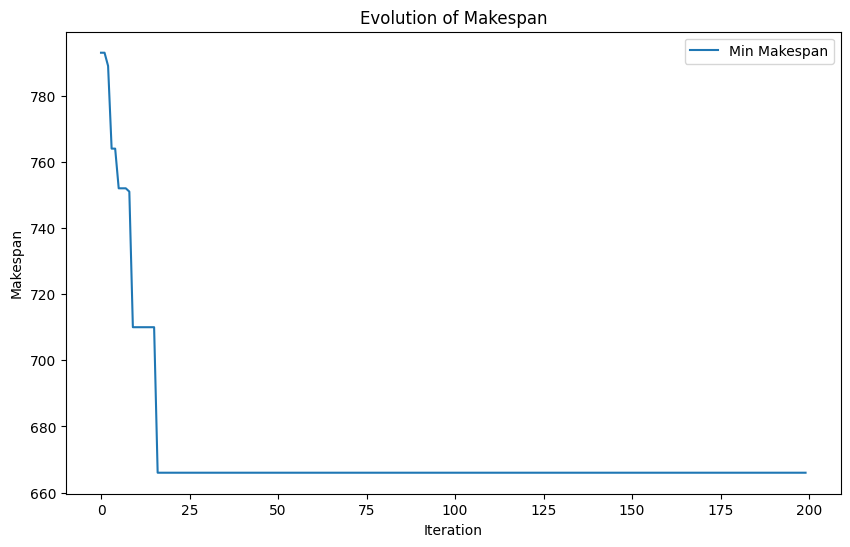

In [20]:
# Plot evolution of makespan
plt.figure(figsize=(10, 6))
plt.plot(min_makespan_record, label="Min Makespan")
#plt.plot(avg_makespan_record, label="Avg Makespan", linestyle="--")
plt.xlabel("Iteration")
plt.ylabel("Makespan")
plt.title("Evolution of Makespan")
plt.legend()
plt.show()

# Plot Gantt Chart for best solution

In [21]:
def draw_gantt_chart(chromosome, p_t, m_seq, title):
    gantt_data = []
    start_t = np.zeros(p_t.shape[0])  # Tracks the start time for each job
    m_time = np.zeros(p_t.shape[1])  # Tracks the time at which each machine will be free
    j_time = np.zeros(p_t.shape[0])  # Tracks the time at which each job will finish
    op_count = np.zeros(p_t.shape[0], dtype=np.int32)  # Operation counter for each job

    # Iterate through the chromosome to generate Gantt chart data
    for i, gene in enumerate(chromosome):
        job = gene  # The current job from the chromosome
        machine = m_seq[job, op_count[job]]  # Get the machine for the current operation
        processing_time = p_t[job, op_count[job]]  # Get the processing time

        # Calculate the start and completion time of the current operation
        start_time = max(j_time[job], m_time[machine])
        completion_time = start_time + processing_time

        # Update job and machine available times
        j_time[job] = completion_time
        m_time[machine] = completion_time

        # Append the Gantt chart data: job, task number, start, finish, machine
        gantt_data.append((job, op_count[job], start_time, completion_time, machine + 1))  # Machine IDs are 1-based
        op_count[job] += 1

    # Convert Gantt chart data into a DataFrame for easier plotting
    df = pd.DataFrame(gantt_data, columns=['Job', 'Task', 'Start', 'Finish', 'Machine'])

    df['Machine_ID'] = df['Machine']  # Already extracted as numeric
    df = df.sort_values(by='Machine_ID')  # Sort by machine ID

    # Assign unique colors for each job
    unique_jobs = df['Job'].unique()
    job_colors = {job: plt.cm.tab20(i / len(unique_jobs)) for i, job in enumerate(unique_jobs)}

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(20, 8))

    # Create Gantt chart bars grouped by machine
    for i, row in df.iterrows():
        color = job_colors[row['Job']]  # Use the job-specific color
        ax.barh(row['Machine'], row['Finish'] - row['Start'], left=row['Start'], height=0.4, color=color,
                edgecolor='black')

        # Add the label inside the bar with format job(i, j)
        ax.text(row['Start'] + (row['Finish'] - row['Start']) / 2, row['Machine'],
                f"job({int(row['Job'])}, {int(row['Task'])})",  # Job and task number as integers
                ha='center', va='center', fontsize=9, color='white' if (row['Finish'] - row['Start']) > 2 else 'black')

    # Add labels and formatting
    ax.set_xlabel('Time')
    ax.set_title(title)
    ax.set_xlim(0, int(max(df['Finish']) + 1))
    ax.set_yticks(range(1, p_t.shape[1] + 1))
    ax.set_yticklabels([f"Machine {i-1}" for i in range(1, p_t.shape[1] + 1)])
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.show()

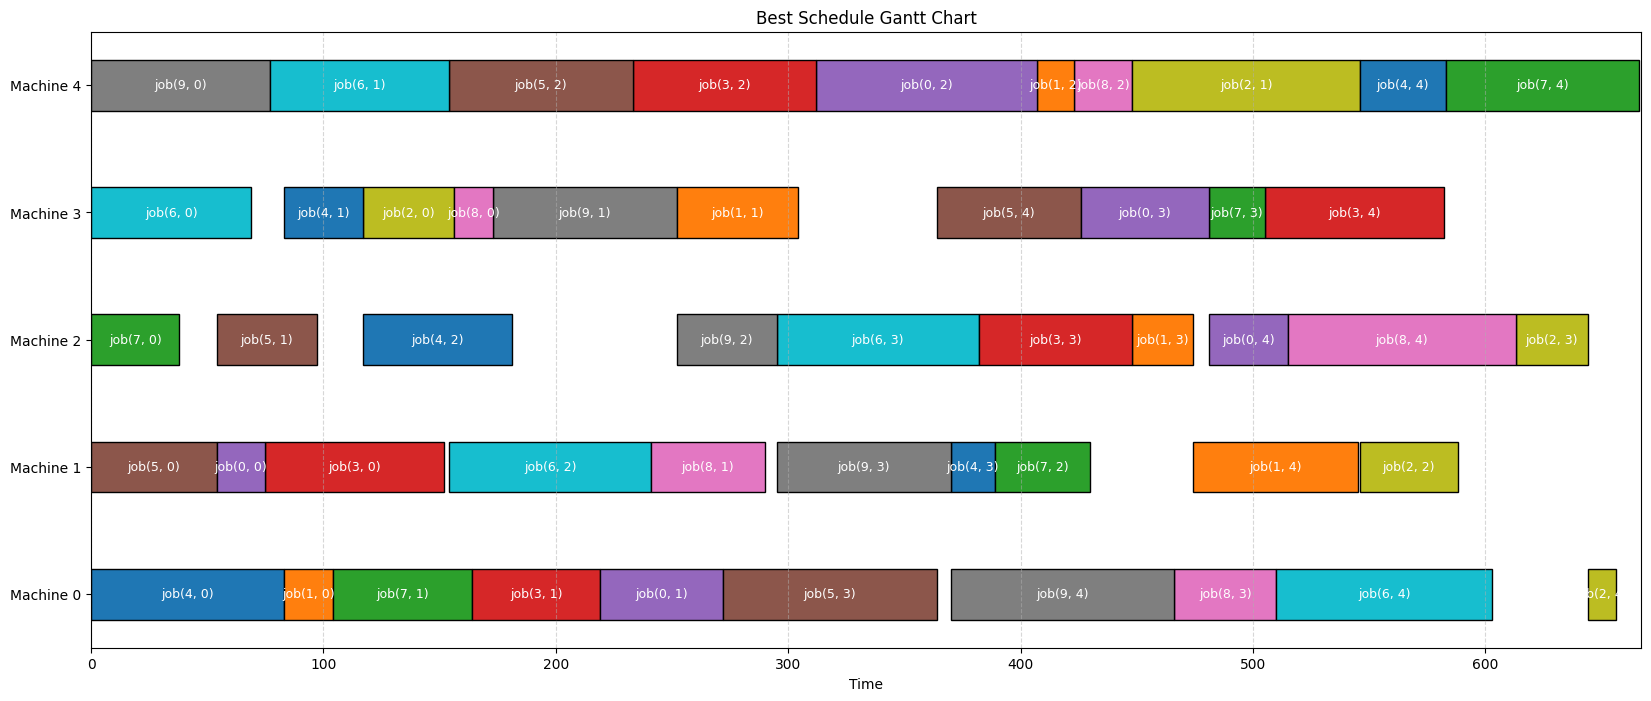

In [22]:
# Generate Gantt chart for the best solution
draw_gantt_chart(best_chromosome, processing_times, machine_sequences, title="Best Schedule Gantt Chart")